

# Binomial logistic regression (Part 1)




Throughout the following exercises, you will learn to use Python to build and evaluate a binomial logistic regression model. Before starting on this programming exercise, we strongly recommend watching the video lecture and completing the IVQ for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

As we move forward, you can find instructions on how to install required libraries as they arise in this notebook. Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using pandas and sickit-learn for operations, and seaborn for plotting.

## Relevant imports

Begin by importing the relevant packages and data.

In [1]:
# Import pandas and seaborn packages
import pandas as pd
import seaborn as sns

## Exploratory data analysis 

**Note:** The following code cell is shown in the video, but it will only work if the .csv file is in the same folder as the notebook. Otherwise, please follow the data loading process outlined above.

In [4]:
# RUN THIS CELL TO IMPORT YOUR DATA.
import snowflake.snowpark as snowpark
from snowflake.snowpark.types import StructType, StructField, StringType, FloatType, IntegerType

def import_data(session: snowpark.Session):
    # Define the path to your staged CSV file 
    file_location = "@MY_CSV_STAGE/activity.csv" 

    # Define the schema based on your uploaded file
    schema_for_file = StructType([
    StructField("AccVertical", FloatType()),   # numeric accelerometer values
    StructField("LyingDown", IntegerType())    # binary categorical (0/1)
])


    # Read the CSV file into a Snowpark DataFrame 
    data = session.read.schema(schema_for_file).option("HEADER", "TRUE").csv(file_location)

    # Return the DataFrame
    return data

# Create a Snowpark session
from snowflake.snowpark import Session

connection_parameters = {
    "account": "********",
    "user": "********",
    "password": "********",
    "role": "********",
    "warehouse": "********",
    "database": "********",
    "schema": "PUBLIC"   # <-- use PUBLIC instead of INFORMATION_SCHEMA
}

session = Session.builder.configs(connection_parameters).create()

# Call the function and assign the result to a variable
activity = import_data(session)
activity.show(5)

# Convert to pandas DataFrame
activity = activity.to_pandas()
activity.head(5)











In [6]:
# Get summary statistics about the dataset
activity.describe()

,Acc (vertical),LyingDown
count,494.000000,494.000000
mean,45.512363,0.516194
std,44.799360,0.500244
min,-48.459000,0.000000
25%,0.918650,0.000000
50%,41.109500,1.000000
75%,89.339000,1.000000
max,112.310000,1.000000


In [7]:
# Examine the dataset
activity.head()

,Acc (vertical),LyingDown
0,96.229,0
1,84.746,0
2,82.449,0
3,106.560,0
4,80.152,0


## Construct binomial logistic regression model

For binomial logistic regression, we'll be using the `scikit-learn` package, which is frequently used for machine learning and more advanced data science topics. For the purposes of this exercise, we'll only load in the functions we need: `train_test_split()` and `LogisticRegression()`.

In [11]:
# Load in sci-kit learn functions for constructing logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Then, we'll save the data into variables called X and y so we can use the `train_test_split()` function more easily. Remember that you can subset specific columns of a DataFrame object by using double square brackets: `[[]]` and listing the columns in between, separated by commas.

In [12]:
# Save X and y data into variables
X = activity[["ACCVERTICAL"]]
y = activity[["LYINGDOWN"]]

Then we'll split the data into training and holdout datasets. We set the `test_size` to `0.3` so that the holdout dataset is only 30% of the total data we have. We'll set the `random_state` equal to `42`. If you change this variable, then your results will be different from ours. Setting the `random_state` is mainly for reproducibility purposes.

In [13]:
# Split dataset into training and holdout datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

Then we'll build our classifier, and fit the model to the data by using the `.fit()` function. We'll save the fitted model as a variable called `clf`.

In [18]:
# clf = LogisticRegression().fit(X_train,y_train)

# warning is pretty common when training models in scikit-learn. It’s telling you that your target variable y_train is shaped like a column vector (e.g. (n_samples, 1)), but scikit-learn expects a 1D array (n_samples,).
# Got it — the issue is that your y_train is a pandas DataFrame, not a NumPy array. Pandas DataFrames don’t have .ravel(), which is why you’re seeing the AttributeError.



# Option 1: Use ravel()
clf = LogisticRegression().fit(X_train, y_train.values.ravel())

## Get coefficients and visualize model

We can use the `coef_` and `intercept_` attributes of the `clf` object to get the coefficient and intercept of our model.

In [19]:
# Print the coefficient
clf.coef_

array([[-0.1177471]])

In [20]:
# Print the intercept
clf.intercept_

array([6.10180958])

So, based on what we've found, our model has an intercept or $\beta_0$ of 6.10 and a $\beta_1$ of -0.12. Now we can plot our model and data with a 95% confidence band using the `regplot()` function from the `seaborn` package. Remember to set the argument `logistic=True` so that the function knows we are plotting a logistic regression model, not a linear regression model.

<Axes: xlabel='Acc (vertical)', ylabel='LyingDown'>

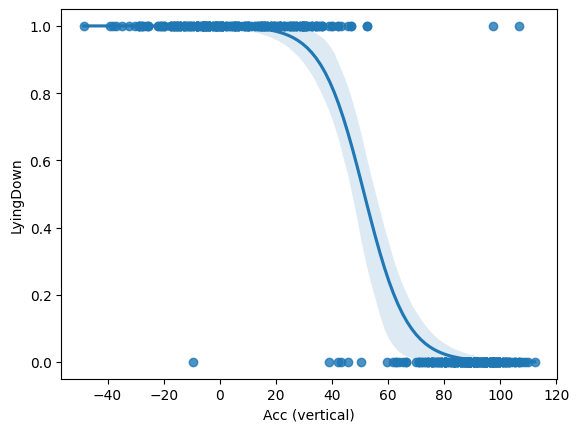

In [21]:
# Plot the logistic regression and its confidence band
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np 

# sns.regplot(x="ACCVERTICAL", y="LYINGDOWN", data=activity, logistic=True)


X = activity[["ACCVERTICAL"]]
y = activity["LYINGDOWN"]

clf = LogisticRegression()
clf.fit(X, y)

x_vals = np.linspace(X.min()[0], X.max()[0], 100).reshape(-1,1)
y_pred = clf.predict_proba(x_vals)[:,1]

plt.scatter(X, y, alpha=0.5)
plt.plot(x_vals, y_pred, color="red")
plt.xlabel("AccVertical")
plt.ylabel("Probability of LyingDown")
plt.title("Logistic Regression Fit")
plt.show()


# Confusion matrix (Part II)

This part of the notebook contains all of the code that will be presented in the second part of this section in the course. The focus is on **confusion matrices**, which are used to evaluate classification models, such as a binomial logistic regression model. 

**Note:** We are assuming that the earlier parts of this notebook have been run, and that the existing variables and imported packages have been saved. 

## Construct logistic regression model

Once again, we split our data, which is currently saved as variables `X` and `y`, into training and holdout datasets using the `train_test_split()` function. The function has already been imported from the `scikit-learn` package. Then, we build the model by using the `LogisticRegression()` function with the `.fit()` function.

Next, we can save our model's predictions by inputting the holdout sample, `X_test` into the model's `.predict()` function.

In [23]:
# Split data into training and holdout samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build regression model
 
clf = LogisticRegression().fit(X_train, y_train.values.ravel())

# Save predictions
y_pred = clf.predict(X_test)

We can print out the predicted labels by just calling on `clf.predict(X_test)`. Recall that 0 means not lying down, and 1 means lying down.

In [24]:
# Print out the predicted labels
clf.predict(X_test)

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1])

But, the model actually calculates a probability that given a particular value of X, the person is lying down. We can print out the predicted probabilities with the following line of code. You can read more about the [`LogisticRegression()` function](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), its attributes, and related functions on the `scikit-learn` website.

In [25]:
# Print out the predicted probabilities
clf.predict_proba(X_test)[::,-1]

array([2.31690858e-02, 9.97511643e-01, 1.04280601e-02, 1.05669826e-03,
       9.99781265e-01, 1.04280601e-02, 4.66008916e-03, 9.95733982e-01,
       9.72344491e-01, 2.31690858e-02, 9.97825656e-01, 1.36210414e-02,
       3.43613958e-02, 9.95733982e-01, 9.98892897e-01, 5.75926041e-02,
       4.77299711e-01, 6.09785081e-03, 9.98732818e-01, 9.92695803e-01,
       3.91400562e-02, 9.31713690e-01, 9.64064069e-01, 1.55636152e-02,
       9.83708684e-01, 1.19193813e-02, 7.55109695e-01, 8.74058541e-01,
       3.43613958e-02, 9.91646480e-01, 1.77761812e-02, 1.19193813e-02,
       9.97152398e-01, 2.64338338e-02, 9.98892897e-01, 1.19193813e-02,
       9.31713690e-01, 9.95119380e-01, 9.00936838e-01, 9.22595259e-01,
       8.39842140e-02, 9.99624404e-01, 1.19193813e-02, 8.01630725e-01,
       5.33097419e-03, 1.36210414e-02, 3.01444198e-02, 3.55969345e-03,
       4.07280935e-03, 1.19193813e-02, 9.98892897e-01, 6.53832873e-02,
       4.07280935e-03, 9.98892897e-01, 9.12054235e-03, 9.53423143e-01,
      

## Create confusion matrix



To finish this part of the course, we'll create a confusion matrix. Recall the following definition:

* **Confusion matrix:** A graphical representation of how accurate a classifier is at predicting the labels for a categorical variable.

To create a confusion matrix, we'll use the [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix) function from the `metrics` module of `scikit-learn`. To use the function, we'll need to input the following:
* Actual labels of the holdout sample, stored as `y_test`
* Predicted labels of the holdout sample, stored as `y_pred`
* The names of the labels, which you can access using `clf.classes_`

**Note:** If there were more classes, we would have more numbers or labels in `clf.classes_`. Since this is a binomial logistic regression, there are only two labels, 0 and 1.

In [26]:
# Import the metrics module from scikit-learn
import sklearn.metrics as metrics

In [27]:
# Calculate the values for each quadrant in the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels = clf.classes_)

In [28]:
# Create the confusion matrix as a visualization
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf.classes_)

In order to understand and interpret the numbers in the below confusion matrix, it is important to keep the following in mind:

* The upper-left quadrant displays the number of **true negatives**.
* The bottom-left quadrant displays the number of **false negatives**.
* The upper-right quadrant displays the number of **false positives**.
* The bottom-right quadrant displays the number of **true positives**.

We can define the above bolded terms as follows in our given context:
* **True negatives**: The number of people that were not lying down that the model accurately predicted were not lying down.
* **False negatives**: The number of people that were lying down that the model inaccurately predicted were not lying down.
* **False positives**: The number of people that were not lying down that the model inaccurately predicted were lying down.
* **True positives**: The number of people that were lying down that the model accurately predicted were lying down.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

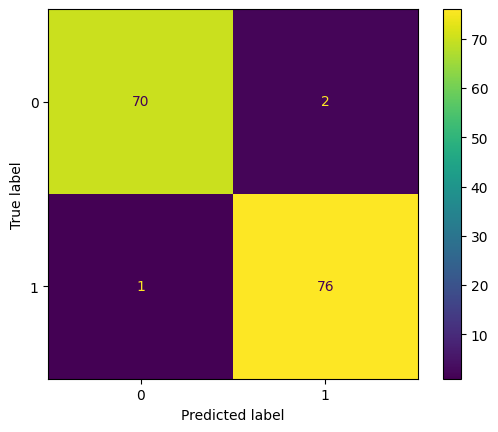

In [29]:
# Display the confusion matrix
disp.plot()

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.

You now understand how to build and evaluate a binomial logistic regression model with Python. Going forward, you can start using binomial logistic regression models with your own datasets.